In [3]:
# Graphics
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily
# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

# Spatial Autocorrelation
https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html

## the EU Referendum

In [4]:
# vote percentages at the local authority level.
brexit_data_path = './data/brexit/brexit_vote.csv'
ref = pandas.read_csv(brexit_data_path, index_col='Area_Code')
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, E06000031 to E08000036
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       382 non-null    int64  
 1   Region_Code              382 non-null    object 
 2   Region                   382 non-null    object 
 3   Area                     382 non-null    object 
 4   Electorate               382 non-null    int64  
 5   ExpectedBallots          382 non-null    int64  
 6   VerifiedBallotPapers     382 non-null    int64  
 7   Pct_Turnout              382 non-null    float64
 8   Votes_Cast               382 non-null    int64  
 9   Valid_Votes              382 non-null    int64  
 10  Remain                   382 non-null    int64  
 11  Leave                    382 non-null    int64  
 12  Rejected_Ballots         382 non-null    int64  
 13  No_official_mark         382 non-null    int64  
 14  Voting_for_both_a

In [5]:
ref.head()

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
E06000031,108,E12000006,East,Peterborough,120892,87474,87469,72.35,87469,87392,34176,53216,77,0,32,7,38,39.11,60.89,0.09
E06000032,109,E12000006,East,Luton,127612,84633,84636,66.31,84616,84481,36708,47773,135,0,85,0,50,43.45,56.55,0.16
E06000033,112,E12000006,East,Southend-on-Sea,128856,93948,93939,72.90,93939,93870,39348,54522,69,0,21,0,48,41.92,58.08,0.07
E06000034,113,E12000006,East,Thurrock,109897,79969,79954,72.75,79950,79916,22151,57765,34,0,8,3,23,27.72,72.28,0.04
E06000055,110,E12000006,East,Bedford,119530,86136,86136,72.06,86135,86066,41497,44569,69,0,26,1,42,48.22,51.78,0.08


In [7]:
# Generalized Clipped Boundaries in the UK WGS84.
lads = geopandas.read_file("./data/brexit/local_authority_districts.geojson")\
                .set_index('lad16cd')
lads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 391 entries, E06000001 to W06000023
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    391 non-null    int64   
 1   lad16nm     391 non-null    object  
 2   lad16nmw    22 non-null     object  
 3   bng_e       391 non-null    int64   
 4   bng_n       391 non-null    int64   
 5   long        391 non-null    float64 
 6   lat         391 non-null    float64 
 7   st_areasha  391 non-null    float64 
 8   st_lengths  391 non-null    float64 
 9   geometry    391 non-null    geometry
dtypes: float64(4), geometry(1), int64(3), object(2)
memory usage: 33.6+ KB


In [8]:
# merge
db = geopandas.GeoDataFrame(lads.join(ref[['Pct_Leave']]), crs=lads.crs)\
              .to_crs(epsg=3857)\
              [['objectid', 'lad16nm', 'Pct_Leave', 'geometry']]\
              .dropna()
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 14.8+ KB


In [9]:
db.head()

,objectid,lad16nm,Pct_Leave,geometry
lad16cd,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-141402.215 7309092.065, -1537..."
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-136924.099 7281563.141, -1426..."
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-126588.382 7293641.928, -1260..."
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-146690.634 7293316.144, -1537..."
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-35191.009 7134866.244, -39368..."


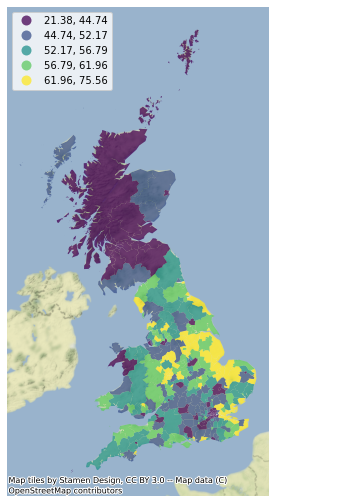

In [10]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(column='Pct_Leave', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax
       )
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

In [11]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = 'R'

## Spatial Lag

In [12]:
db['Pct_Leave_lag'] = weights.spatial_lag.lag_spatial(w, db['Pct_Leave'])

In [13]:
db.loc[['E08000012', 'S12000019'], 
       ['Pct_Leave', 'Pct_Leave_lag']]

,Pct_Leave,Pct_Leave_lag
lad16cd,,
E08000012,41.81,54.61375
S12000019,37.94,38.01875


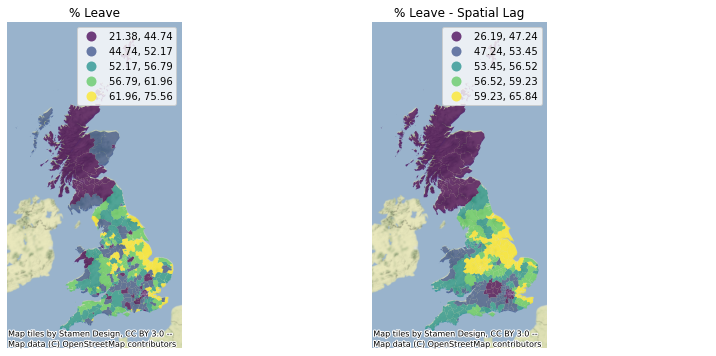

In [14]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(column='Pct_Leave', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax1)
ax1.set_axis_off()
ax1.set_title("% Leave")
contextily.add_basemap(ax1, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

db.plot(column='Pct_Leave_lag', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2)
ax2.set_axis_off()
ax2.set_title("% Leave - Spatial Lag")
contextily.add_basemap(ax2, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

plt.show()

## Moran Plot and Moran’s I

In [15]:
# pct_leave和pct_leave_lag標準化
db['Pct_Leave_std'] = ( db['Pct_Leave'] - db['Pct_Leave'].mean() )\
                    / db['Pct_Leave'].std()
db['Pct_Leave_lag_std'] = ( db['Pct_Leave_lag'] - db['Pct_Leave_lag'].mean() )\
                    / db['Pct_Leave_lag'].std()

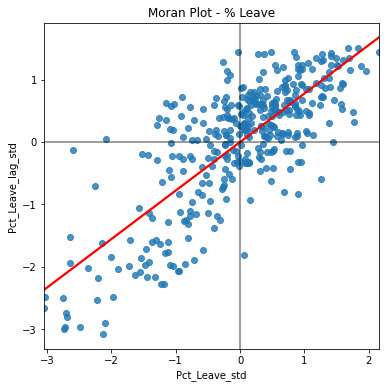

In [16]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(x='Pct_Leave_std', y='Pct_Leave_lag_std', 
                ci=None, data=db, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Leave')
plt.show()

In [17]:
# 計算moran's i
w.transform = 'R'
moran = esda.moran.Moran(db['Pct_Leave'], w)
moran.I

0.6454521298096587

In [19]:
# empirical p-value:夠小的p-vale允許拒絕地圖是隨機的假設
moran.p_sim

0.001

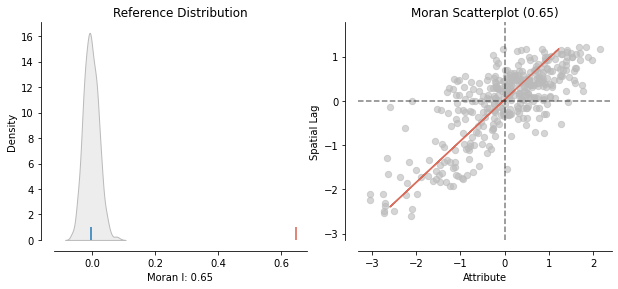

In [20]:
plot_moran(moran);

## Geary’s C

In [21]:
geary = esda.geary.Geary(db['Pct_Leave'], w)
geary.C

0.4080233215854691

In [22]:
geary.p_sim

0.001

---
# Local Autocorrelation
https://geographicdata.science/book/notebooks/07_local_autocorrelation.html

In [23]:
db['w_Pct_Leave'] = weights.spatial_lag.lag_spatial(w, db['Pct_Leave'])

In [24]:
db['Pct_Leave_std'] = ( db['Pct_Leave'] - db['Pct_Leave'].mean() )\
                    / db['Pct_Leave'].std()
db['w_Pct_Leave_std'] = ( db['w_Pct_Leave'] - db['Pct_Leave'].mean() )\
                    / db['Pct_Leave'].std()

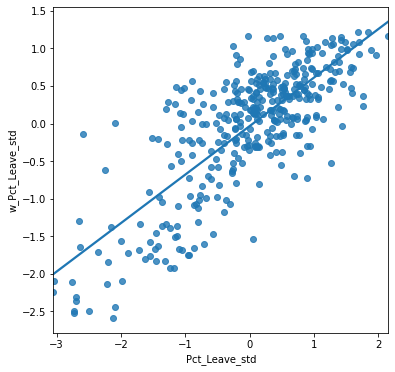

In [25]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=db, ci=None)
# Display
plt.show()

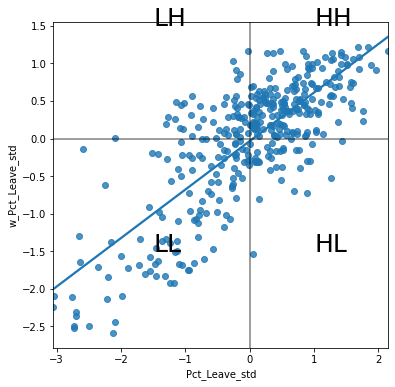

In [26]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

In [27]:
# 計算LISA
lisa = esda.moran.Moran_Local(db['Pct_Leave'], w)

<AxesSubplot:ylabel='Density'>

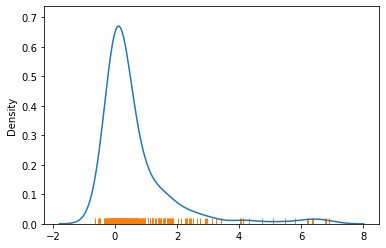

In [28]:
ax = seaborn.kdeplot(lisa.Is)
seaborn.rugplot(lisa.Is, ax=ax)

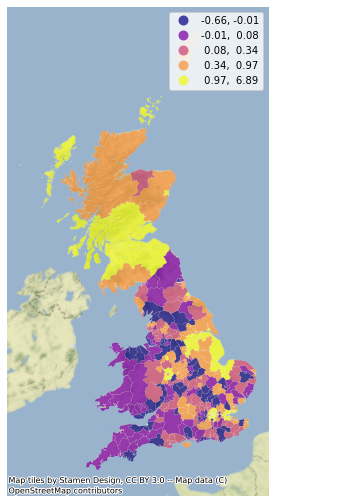

In [29]:
f, ax = plt.subplots(1, figsize=(9,9))
db['Is'] = lisa.Is
db.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

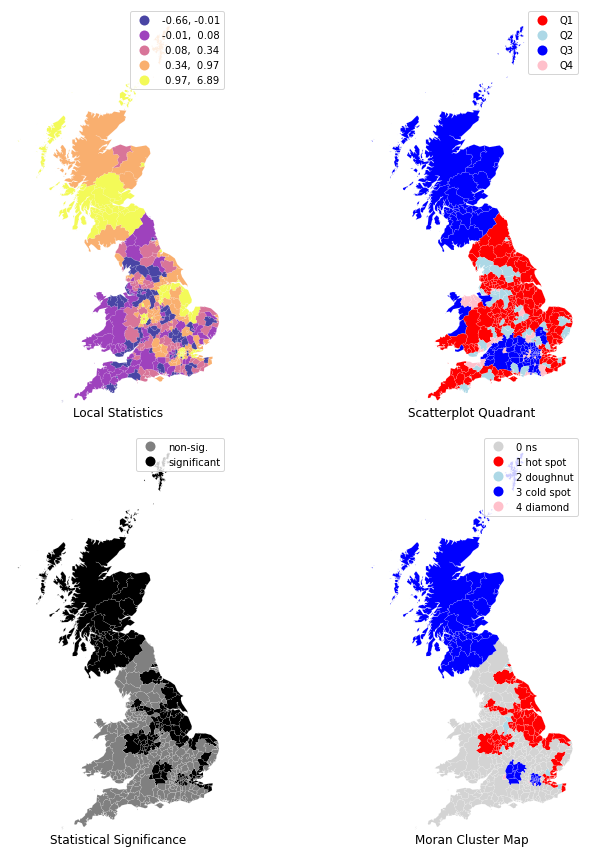

In [30]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
db.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)

                    # Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                    # Subplot 3 #

ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = colors.ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                       
                    # Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])


db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(['Local Statistics', 
                  'Scatterplot Quadrant', 
                  'Statistical Significance', 
                  'Moran Cluster Map'][i], y=0)

f.tight_layout()

# Display the figure
plt.show()

In [27]:
# 計算面積數 
# 1: HH
# 2: LH
# 3: LL
# 4: HL
counts = pandas.value_counts(lisa.q)
counts

1    183
3    113
2     50
4     34
dtype: int64

In [28]:
sig = 1 * (lisa.p_sim < 0.05)
db['p-sim'] = lisa.p_sim
db['sig'] = sig
db[['sig','p-sim']].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.010
E06000002,1,0.010
E06000003,1,0.016
E06000004,1,0.011
E06000010,1,0.019


In [29]:
db[['sig','p-sim']].tail()

,sig,p-sim
lad16cd,,
W06000018,0,0.472
W06000019,0,0.490
W06000021,0,0.497
W06000022,0,0.346
W06000023,0,0.313
